Yaw: 3.87° - Looking Straight


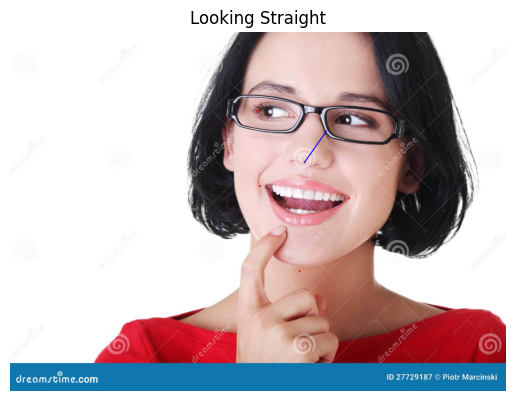

In [14]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

# Load face detector and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Download this file

# Read Image
im = cv2.imread("looking left.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = detector(gray)
if len(faces) == 0:
    print("No face detected!")
    exit()

# Get the first detected face
face = faces[0]

# Get facial landmarks
landmarks = predictor(gray, face)

# Extract key points (corresponding to our original manual points)
image_points = np.array([
    (landmarks.part(30).x, landmarks.part(30).y),  # Nose tip
    (landmarks.part(8).x, landmarks.part(8).y),    # Chin
    (landmarks.part(36).x, landmarks.part(36).y),  # Left eye left corner
    (landmarks.part(45).x, landmarks.part(45).y),  # Right eye right corner
    (landmarks.part(48).x, landmarks.part(48).y),  # Left mouth corner
    (landmarks.part(54).x, landmarks.part(54).y)   # Right mouth corner
], dtype="double")

# 3D model points
model_points = np.array([
    (0.0, 0.0, 0.0),          # Nose tip
    (0.0, -330.0, -65.0),     # Chin
    (-225.0, 170.0, -135.0),  # Left eye left corner
    (225.0, 170.0, -135.0),   # Right eye right corner
    (-150.0, -150.0, -125.0), # Left mouth corner
    (150.0, -150.0, -125.0)   # Right mouth corner
])

# Camera internals
size = im.shape
focal_length = size[1]
center = (size[1] / 2, size[0] / 2)
camera_matrix = np.array([
    [focal_length, 0, center[0]],
    [0, focal_length, center[1]],
    [0, 0, 1]
], dtype="double")

dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion

# SolvePnP to get rotation vector and translation vector
success, rotation_vector, translation_vector = cv2.solvePnP(
    model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

# Convert rotation vector to rotation matrix
rotation_matrix, _ = cv2.Rodrigues(rotation_vector)

# Extract Euler angles (yaw, pitch, roll)
theta_x = np.arctan2(rotation_matrix[2][1], rotation_matrix[2][2])  # Pitch
theta_y = np.arctan2(-rotation_matrix[2][0], 
                     np.sqrt(rotation_matrix[2][1]**2 + rotation_matrix[2][2]**2))  # Yaw
theta_z = np.arctan2(rotation_matrix[1][0], rotation_matrix[0][0])  # Roll

# Convert to degrees
yaw = np.degrees(theta_y)

# Determine direction
if yaw > 15:
    head_pose = "Looking Right"
elif yaw < -15:
    head_pose = "Looking Left"
else:
    head_pose = "Looking Straight"

print(f"Yaw: {yaw:.2f}° - {head_pose}")

# Project a 3D point to the image plane (to visualize head direction)
(nose_end_point2D, jacobian) = cv2.projectPoints(
    np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

# Draw landmarks
for p in image_points:
    cv2.circle(im, (int(p[0]), int(p[1])), 3, (0, 0, 255), -1)

# Draw line indicating nose direction
p1 = (int(image_points[0][0]), int(image_points[0][1]))
p2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
cv2.line(im, p1, p2, (255, 0, 0), 2)

# Convert BGR to RGB for Matplotlib
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Display Image
plt.imshow(im_rgb)
plt.axis("off")
plt.title(head_pose)  # Show detected head pose as title
plt.show()
